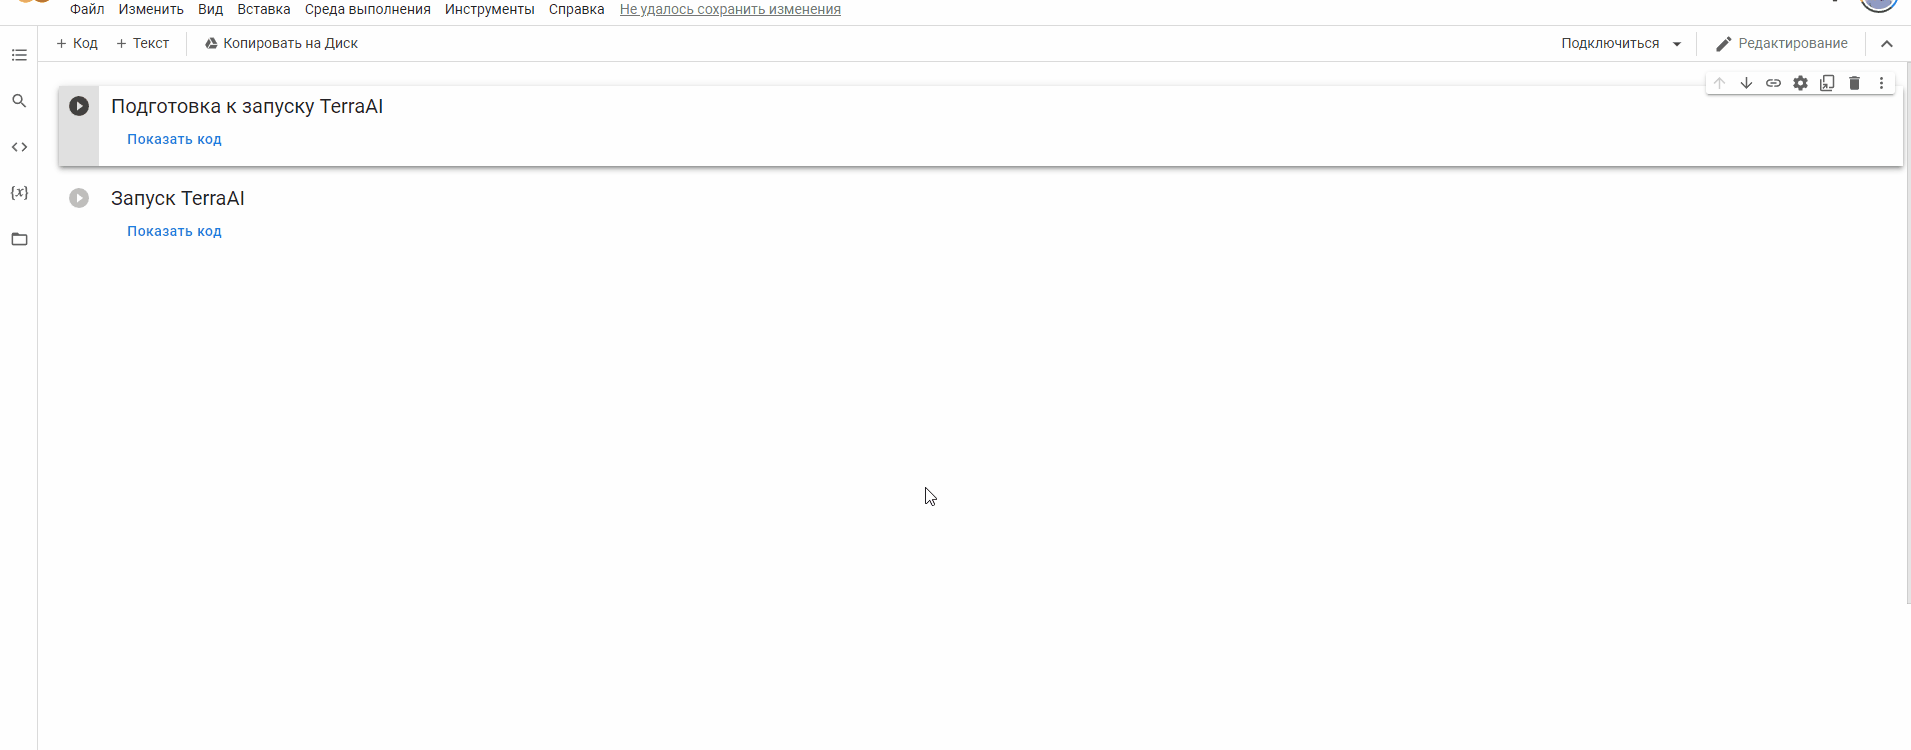

In [ ]:
#@title Подготовка к запуску TerraAI

import os, json
from time import sleep
from enum import Enum
from pathlib import Path
from typing import Tuple
from ipywidgets import widget, Text, Password, Button, VBox, HBox, Layout


TERRA_REPOSITORY = "https://github.com/aiuniver/terra_gui.git"
TERRA_SERVER_API = "http://terra.neural-university.ru/api/v1"
TERRA_DIRECTORY = "terra"


class WebServerException(Exception):
    pass


class State(str, Enum):
    idle = "idle"
    launch = "launch"
    restore_token = "restore_token"


def show_exception(message:WebServerException):
    errors = message.args[0]
    if isinstance(errors, dict):
        for item in errors.values():
            print(f'\033[1;31m{str(", ".join(item) if isinstance(item, list) else item)}\033[0m')
    else:
        print(f"\033[1;31m{str(errors)}\033[0m")


def handler_change_field(field):
    ws.gui.launch_button.disabled = not (ws.gui.email_field.value and ws.gui.token_field.value)
    ws.gui.restore_token_button.disabled = not ws.gui.email_field.value


def handler_start_launch(button):
    ws.gui.display()
    if not (ws.gui.email_field.value and ws.gui.token_field.value):
        return
    ws.gui.state = State.launch
    try:
        ws.start()
    except WebServerException as error:
        show_exception(error)
        ws.gui.state = State.idle
        ws.gui.launch_button.disabled = not (ws.gui.email_field.value and ws.gui.token_field.value)


def handler_restore_token(button):
    ws.gui.display()
    ws.gui.state = State.restore_token
    try:
        ws.restore_token()
        print(f"\033[1;32mНа E-mail {ws.gui.email_field.value} отправлено письмо с новым токеном\033[0m")
    except WebServerException as error:
        show_exception(error)
    ws.gui.state = State.idle


class WebServerGUI:
    email_value: str = ""
    token_value: str = ""

    email_field: Text
    token_field: Password
    launch_button: Button
    restore_token_button: Button

    def __init__(self):
        self.email_field = Text(placeholder="Введите E-mail", disabled=True, layout=Layout(width="300px"))
        self.token_field = Password(placeholder="Введите Token", disabled=True, layout=Layout(width="300px"))
        self.launch_button = Button(description="Авторизация", disabled=True, layout=Layout(width="148px"))
        self.restore_token_button = Button(description="Восстановить токен", disabled=True, layout=Layout(width="148px"))

        self.email_field.on_submit(handler_start_launch)
        self.email_field.observe(handler_change_field, names=["value"])

        self.token_field.on_submit(handler_start_launch)
        self.token_field.observe(handler_change_field, names=["value"])

        self.launch_button.on_click(handler_start_launch)
        self.restore_token_button.on_click(handler_restore_token)

    @property
    def state(self) -> Tuple[bool, bool, bool, bool]:
        return (
            not self.email_field.disabled,
            not self.token_field.disabled,
            not self.launch_button.disabled,
            not self.restore_token_button.disabled,
        )

    @state.setter
    def state(self, value:State):
        if value == State.idle:
            self.email_field.disabled = False
            self.token_field.disabled = False
            self.launch_button.disabled = not (self.email_field.value and self.token_field.value)
            self.restore_token_button.disabled = not self.email_field.value
        elif value == State.restore_token:
            self.email_field.disabled = True
            self.token_field.disabled = True
            self.launch_button.disabled = True
            self.restore_token_button.disabled = True
        elif value == State.launch:
            self.email_field.disabled = True
            self.token_field.disabled = True
            self.launch_button.disabled = True
            self.restore_token_button.disabled = True

    def display(self):
        output.clear()
        # widget.display(
        #     VBox(
        #         [
        #             self.email_field,
        #             self.token_field,
        #             HBox([self.launch_button, self.restore_token_button]),
        #         ]
        #     )
        # )
        self.email_value = input("E-mail: ")
        from getpass import getpass
        self.token_value = getpass("Token: ")

    def init(self):
        self.state = State.idle
        self.display()


class WebServer:
    _path:Path = Path(os.path.abspath(os.getcwd()))
    _url:str = ""
    _data:dict = {}

    gui:WebServerGUI = WebServerGUI()

    def _auth(self):
        try:
            response = requests.post(
                f"{TERRA_SERVER_API}/login/",
                json={"email": self.gui.email_value, "user_token": self.gui.token_value},
            )
        except Exception as error:
            raise WebServerException(error)

        if not response.ok:
            try:
                response.raise_for_status()
            except requests.exceptions.HTTPError as error:
                raise WebServerException(error)

        data = response.json()
        if not data.get("success"):
            raise WebServerException(data.get("error"))

        self._url = data.get("data", {}).get("url", "")
        if not self._url:
            raise WebServerException("Не определен URL для пользовательского интерфейса")

        self._data = data.get("data", {})

    def _download(self):
        _terra_path = Path(self._path, TERRA_DIRECTORY)
        shutil.rmtree(_terra_path, ignore_errors=True)
        try:
            Repo.clone_from(TERRA_REPOSITORY, _terra_path)
        except Exception as error:
            raise WebServerException(error)

    def _prepare(self):
        _terra_path = Path(self._path, TERRA_DIRECTORY)
        for name, info in self._data.get("create", {}).items():
            with open(Path(_terra_path, info.get("name")), "w") as _file_ref:
                _file_ref.write(info.get("data"))

    def init(self):
        self.gui.init()
        self.start()

    def start(self):
        print("Ожидайте! Идет подготовка к запуску TerraAI...")
        self._auth()
        self._download()
        self._prepare()
        print(f"\033[1;32mПосле запуска TerraAI будет доступна по следующей ссылке {self._url}\033[0m")

    def restore_token(self):
        try:
            response = requests.post(
                f"{TERRA_SERVER_API}/restore-token/",
                json={"email": self.gui.email_field.value},
            )
        except Exception as error:
            raise WebServerException(error)

        if not response.ok:
            try:
                response.raise_for_status()
            except requests.exceptions.HTTPError as error:
                raise WebServerException(error)

        data = response.json()
        if not data.get("success"):
            raise WebServerException(data.get("error"))


from google.colab import drive, output

%cd /content
output.clear()

mounted = False
try:
    drive.mount("/content/drive")
    mounted = True
except ValueError as error:
    output.clear()
    show_exception(WebServerException("Не удалось подключиться к GoogleDrive"))
except KeyboardInterrupt as error:
    pass

ws = WebServer()

if mounted:
    output.clear()
    print("Начало установки. Процесс может занять несколько минут, ожидайте...")
    !pip install git+https://github.com/aiuniver/terra_colab.git &> /dev/null
    print("Установка завершена!")
    sleep(1)
    output.clear()

    import shutil
    import signal
    import requests
    from git import Repo
    from subprocess import Popen, PIPE, STDOUT

    try:
        ws.init()
    except WebServerException as error:
        show_exception(error)
        ws.gui.state = State.idle


In [ ]:
#@title Запуск TerraAI

import sys, psutil, signal

def sigint_handler(signal, frame):
    sys.exit(0)

signal.signal(signal.SIGINT, sigint_handler)

for item in psutil.process_iter():
    if item.status() == "zombie":
        continue
    if item.cwd() != "/content/terra":
        continue
    psutil.Process(item.pid).terminate()

!make -C /content/terra 2>&1 | tee /content/terra/logs.txt